In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.options.display.max_rows = 47276
pd.options.display.max_columns = 20000

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

In [2]:
root = os.path.join(os.getcwd(), 'DATA')

In [3]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))
oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
weather = pd.read_csv(os.path.join(root, 'preprocessed_weather.csv'))
kor_weather = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))

In [4]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)

################################################################################################################################################################

def fillna(data, all_nation, major_nation , method=None):
  
  '''

  주요 수출구 결측치 제거 함수
  all_nation = 모든 수출국
  major_nation = 주요 수출국 ['칠레', '중국', '노르웨이', '페루', '태국', '베트남']
  method = ffill, bfill

  '''

  for nation in all_nation:
    for m_nation in major_nation:
      if nation == m_nation:

        if method == 'ffill':
          data[data['CTRY_2'] == m_nation].fillna(method='ffill', inplace=True)

        elif method == 'bfill':
          data[data['CTRY_2'] == m_nation].fillna(method='ffill', inplace=True)

################################################################################################################################################################

def na_list(data):

  '''
  결측치 컬럼 확인
  '''
  lst = []
  for col in data.columns:
    if data[col].isna().sum() > 0 :
      lst.append(col)
    else: pass

  return lst

################################################################################################################################################################

def drop_col(data):
  '''
  결측치 컬럼 제거
  '''
  lst = na_list(data)
  data.drop(lst, axis=1,inplace=True)

################################################################################################################################################################

def scaler_col(data, col, method):
  '''
  전처리 함수
  data 
  col : ['cpi_total', 'cpi_fish', 'oil', 'wind_kr', 'temperature_kr','water_temp_kr']
  method : standard, minmax, robust, log
  '''
  if method == 'standard':
    scaler = StandardScaler()
    data[col] = scaler.fit_transform(data[col])

  elif method == 'minmax':
    scaler = StandardScaler()
    data[col] = scaler.fit_transform(data[col])

  elif method == 'robust':
    scaler = StandardScaler()
    data[col] = scaler.fit_transform(data[col])

  elif method == 'log':
    data[col] = np.log1p(data[col])

################################################################################################################################################################

def make_quarter(data, col):
  '''
  분기 행 추가
  col : 'REG_DATE'
  '''
  data[col] = pd.to_datetime(data[col])
  data['Quarter'] = data[col].dt.quarter
  data['Quarter_ver2'] = data['Quarter'] + (data['year'] - data['year'].min()) * 4
  dummies = pd.get_dummies(df_train['Quarter'], prefix='Quater_Dummy', drop_first=True)

  if 'Quarter' in data.columns:
    data = pd.concat([data, dummies], axis=1)
    del data['Quarter']

################################################################################################################################################################
################################################################################################################################################################

def nation_week_df(data,days, nation, kind):
  '''
  
  국가 종류별 주차별 가격 평균 df  및 결측값 채움.
  data = df
  days = set(df_copy['REG_DATE'])
  nation = 국가이름
  kind = 종류이름
  
  '''
  kind_lst = []
  price_lst = []
  temp_df = pd.DataFrame()

  for day in days:
    nation_kind = data[(data['CTRY_2'] == nation) & (data['REG_DATE'] == day) & (data['P_NAME'] == kind)]
    kind_lst.append(nation_kind)
  kind_df = pd.concat(kind_lst, axis=0).sort_values(by='REG_DATE').reset_index(drop=True)

  for day in days:
    price_lst.append(kind_df[ (kind_df['REG_DATE'] == day) ]['P_PRICE'].mean())

  temp_df = temp_df.append(price_lst)
  temp_df = temp_df.dropna().reset_index(drop=True)
  temp = list(temp_df.iloc[:,0])
  kind_df = kind_df.drop_duplicates('REG_DATE').reset_index(drop=True)
  
  kind_df['P_PRICE'] = temp
  kind_df.set_index('REG_DATE', inplace=True)
  kind_df = kind_df.asfreq('W-mon')

  kind_df.fillna(method = 'ffill', inplace= True)

  return kind_df

################################################################################################################################################################

def last_result(data, days ,nation, kind, dummy_list):
  
  '''
  dummy_list = ['CTRY_1','CTRY_2','P_PURPOSE','CATEGORY_1','CATEGORY_2','P_NAME']

  '''

  df = nation_week_df(data, days, nation, kind)
  import_type_list = set()

  for tmp in df['P_IMPORT_TYPE'].unique():
    for i in tmp.split(','):
      import_type_list.add(i)

  for name in import_type_list:
    df[name] = 0
    df.loc[df['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

  result = pd.get_dummies(data = df, columns = dummy_list)

  result.drop("P_IMPORT_TYPE", axis=1, inplace=True)

  return result

In [5]:
set_week(df_raw, 'REG_DATE')

In [6]:
df_train = pd.merge(df_raw, cpi, how='left', on=['year','week'])
df_train = pd.merge(df_train, oil, how='left', on=['year','week'])
df_train = pd.merge(df_train, weather, how='left', on=['year','week', 'CTRY_1'])
df_train = pd.merge(df_train, kor_weather, how='left', on=['year','week'])
df_train = pd.merge(df_train, exchange, how='left', on=['year','week','CTRY_2'])
df_train.drop('P_TYPE', axis=1, inplace=True)

In [7]:
all_nation = list(set(df_train['CTRY_2']))
major_nation = ['칠레', '중국', '노르웨이', '페루', '태국', '베트남']

In [8]:
fillna(data = df_train, all_nation = all_nation, major_nation = major_nation, method = 'ffill')
drop_col(df_train) ## 결측 행 제거
df_train = df_train.drop_duplicates() # 왜인지 모르겠지만 중복행이 존재함
make_quarter(df_train, 'REG_DATE')

# 중국 흰다리 새우 예시

In [9]:
day_list = set(df_train['REG_DATE'])
dummy = ['CTRY_1','CTRY_2','P_PURPOSE','CATEGORY_1','CATEGORY_2','P_NAME']
final_df = last_result(data = df_train, days =  day_list, nation = '중국', kind = '흰다리새우', dummy_list=dummy)

In [10]:
scaler_lst = ['cpi_total', 'cpi_fish', 'oil', 'wind_kr', 'temperature_kr','water_temp_kr']
scaler_col(df_train, scaler_lst, method='log') # 데이터 정규화

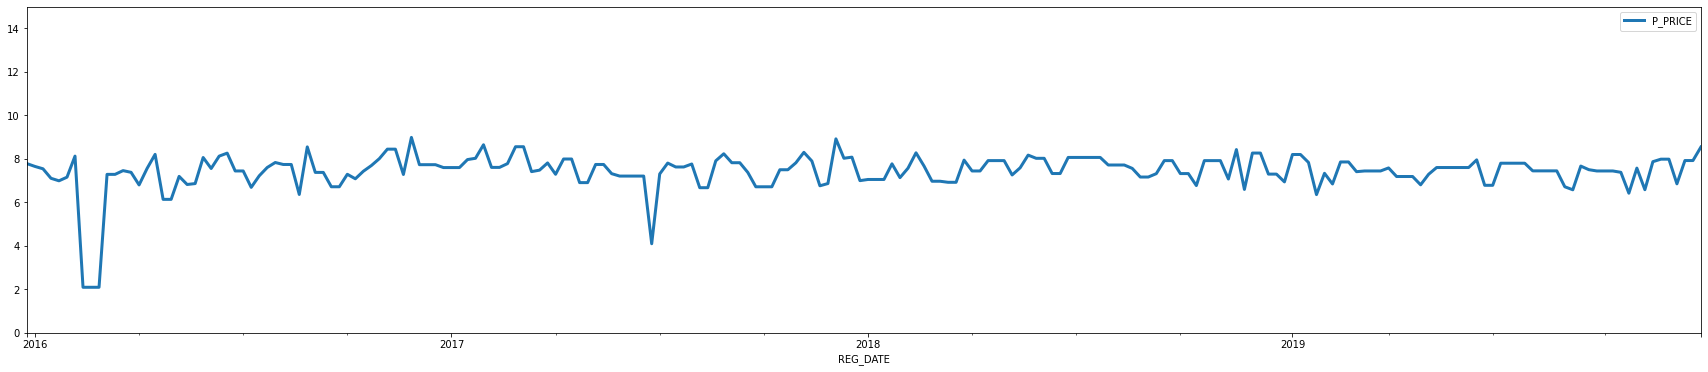

In [11]:
final_df[['P_PRICE',]].plot(kind='line', figsize = (30, 6), linewidth=3, xlim=('2015-12-28', '2019-12-30'),
                          ylim=(0, 15))
plt.show()

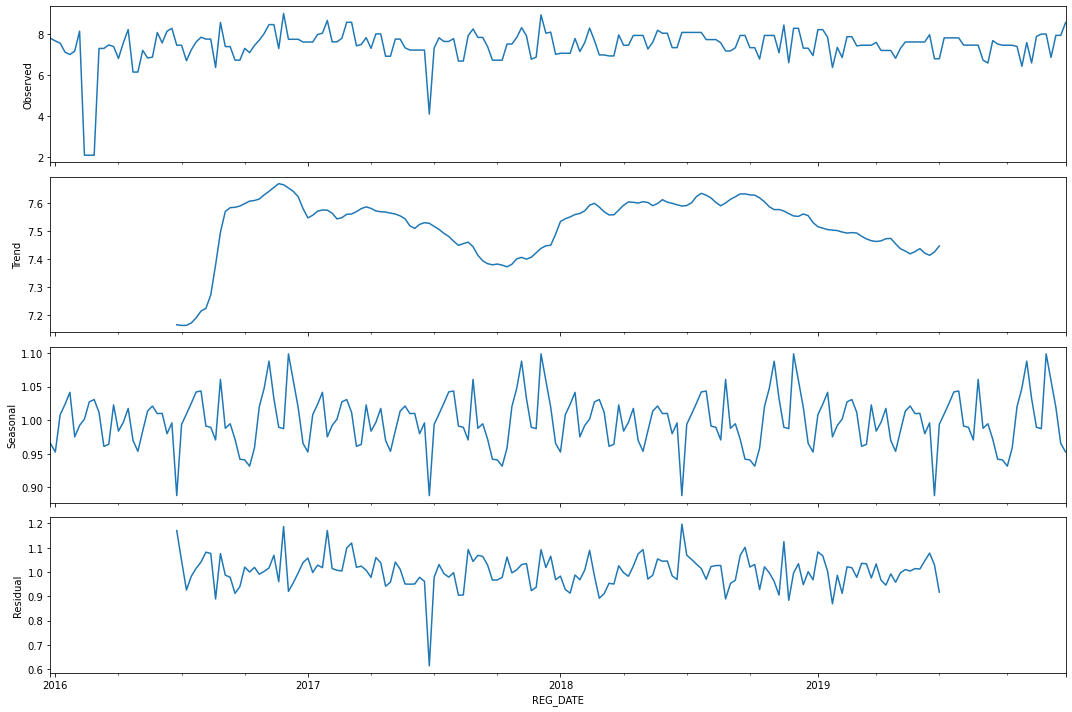

In [12]:
plt.rcParams['figure.figsize'] = (15, 10)

sm.tsa.seasonal_decompose(final_df[['P_PRICE']], model='multiplicative').plot()
plt.show()

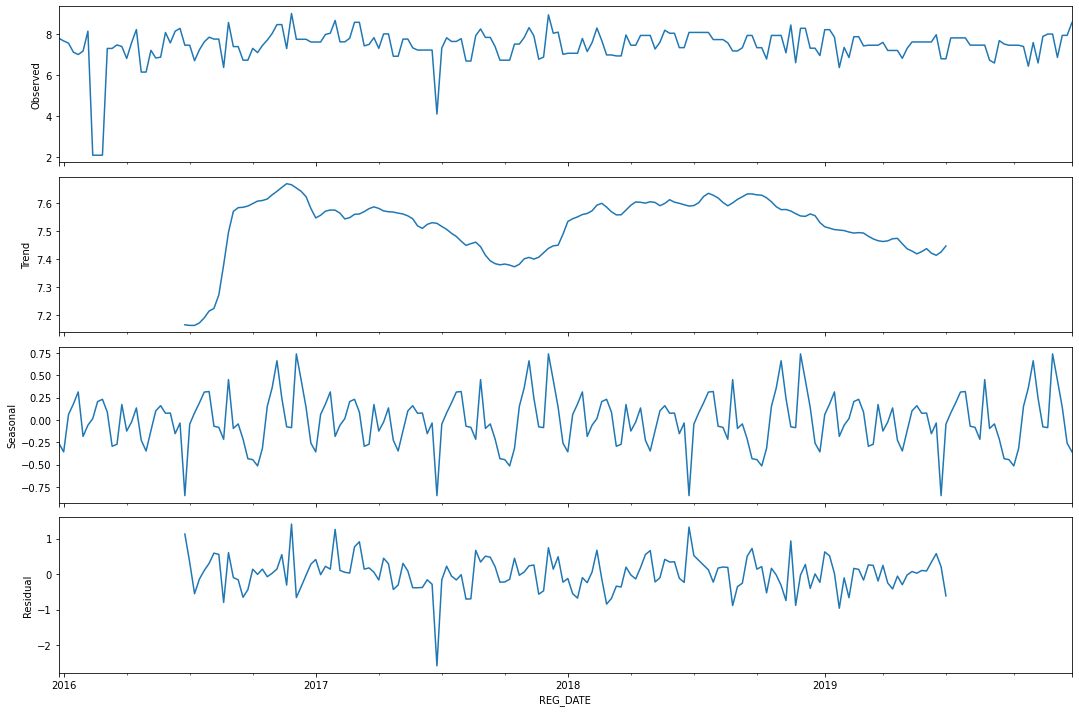

In [13]:
plt.rcParams['figure.figsize'] = (15, 10)

sm.tsa.seasonal_decompose(final_df[['P_PRICE']], model='additive').plot()
plt.show()


result = sm.tsa.seasonal_decompose(final_df['P_PRICE'], model='additive')

In [14]:
pd.DataFrame(result.resid).describe()

,P_PRICE
count,158.000000
mean,0.020680
std,0.486582
min,-2.581122
25%,-0.230814
50%,0.028752
75%,0.269627
max,1.410141


In [15]:
trend = pd.DataFrame(result.trend)
trend.fillna(method='ffill', inplace=True)
trend.fillna(method='bfill', inplace=True)
trend.columns = ['price_trend']

In [16]:
seasonal = pd.DataFrame(result.seasonal)
seasonal.fillna(method='ffill', inplace=True)
seasonal.fillna(method='bfill', inplace=True)
seasonal.columns = ['price_seasonal']

In [17]:
if 'trend' not in final_df.columns:
  if 'seasonal' not in final_df.columns:
    final_df = pd.concat([final_df, trend, seasonal], axis=1)

In [18]:
final_df.tail(3)

,P_PRICE,year,week,cpi_total,cpi_fish,oil,wind_kr,temperature_kr,water_temp_kr,Quarter,Quarter_ver2,냉동,자숙,살,CTRY_1_중국,CTRY_2_중국,P_PURPOSE_판매용,CATEGORY_1_갑각류,CATEGORY_2_새우,P_NAME_흰다리새우,price_trend,price_seasonal
REG_DATE,,,,,,,,,,,,,,,,,,,,,,
2019-12-16,7.926250,2019.0,51.0,105.12,116.99,60.748,6.806122,9.477551,14.470068,4.0,20.0,1,0,1,1,1,1,1,1,1,7.446659,0.141733
2019-12-23,7.926250,2019.0,51.0,105.12,116.99,60.748,6.806122,9.477551,14.470068,4.0,20.0,1,0,1,1,1,1,1,1,1,7.446659,-0.259498
2019-12-30,8.550072,2020.0,1.0,105.12,116.99,61.660,6.534266,6.942657,13.188652,4.0,24.0,1,0,1,1,1,1,1,1,1,7.446659,-0.356770


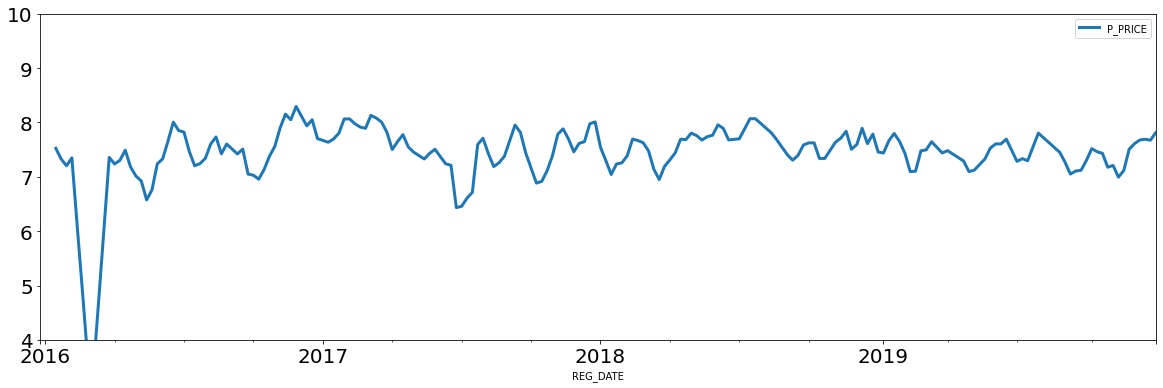

In [19]:

final_df[['P_PRICE']].rolling(4).mean().plot(kind='line', figsize=(20, 6),
                                              linewidth=3, fontsize=20,
                                              xlim=('2015-12-28	','2019-12-30'), 
                                              ylim = (4, 10))

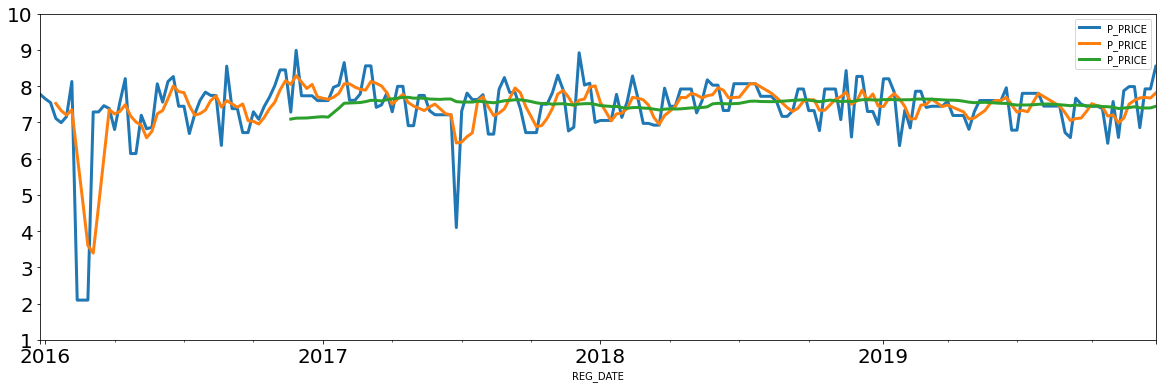

In [20]:
pd.concat([final_df[['P_PRICE']],
           final_df[['P_PRICE']].rolling(4).mean(),
           final_df[['P_PRICE']].rolling(4 * 12).mean()], axis=1).plot(kind='line', figsize=(20, 6),
                                              linewidth=3, fontsize=20,
                                              xlim=('2015-12-28	','2019-12-30'), 
                                              ylim = (1, 10))

plt.show()

In [21]:
count_Day = final_df[['P_PRICE']].rolling(4).mean()
count_Day.fillna(method='ffill', inplace=True)
count_Day.fillna(method='bfill', inplace=True)
count_Day.columns = ['count_Day']

count_Week = final_df[['P_PRICE']].rolling(4 * 12).mean()
count_Week.fillna(method='ffill', inplace=True)
count_Week.fillna(method='bfill', inplace=True)
count_Week.columns = ['count_Week']

if 'count_Day' not in final_df.columns:
  final_df = pd.concat([final_df, count_Day], axis=1)

if 'count_Week' not in final_df.columns:
  final_df = pd.concat([final_df, count_Week], axis=1)

final_df.head()

,P_PRICE,year,week,cpi_total,cpi_fish,oil,wind_kr,temperature_kr,water_temp_kr,Quarter,Quarter_ver2,냉동,자숙,살,CTRY_1_중국,CTRY_2_중국,P_PURPOSE_판매용,CATEGORY_1_갑각류,CATEGORY_2_새우,P_NAME_흰다리새우,price_trend,price_seasonal,count_Day,count_Week
REG_DATE,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28,7.785059,2015.0,53.0,100.22,101.26,37.080,5.352941,7.973109,13.732174,4.0,4.0,1,0,1,1,1,1,1,1,1,7.164766,-0.259498,7.524373,7.092923
2016-01-04,7.655120,2016.0,1.0,100.39,100.76,34.626,6.739496,6.356303,13.282051,1.0,5.0,1,1,1,1,1,1,1,1,1,7.164766,-0.356770,7.524373,7.092923
2016-01-11,7.547201,2016.0,2.0,100.39,100.76,30.450,6.095798,5.514286,12.835593,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.061766,7.524373,7.092923
2016-01-18,7.110114,2016.0,3.0,100.39,100.76,29.350,9.819643,0.268750,11.728319,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.178875,7.524373,7.092923
2016-01-25,6.994303,2016.0,4.0,100.39,100.76,32.186,7.211224,4.908163,11.227000,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.314334,7.326684,7.092923


In [22]:
final_df[['P_PRICE']].diff()

,P_PRICE
REG_DATE,
2015-12-28,NaN
2016-01-04,-0.129938
2016-01-11,-0.107919
2016-01-18,-0.437087
2016-01-25,-0.115811
2016-02-01,0.167346
2016-02-08,0.968560
2016-02-15,-6.032506
2016-02-22,0.000000


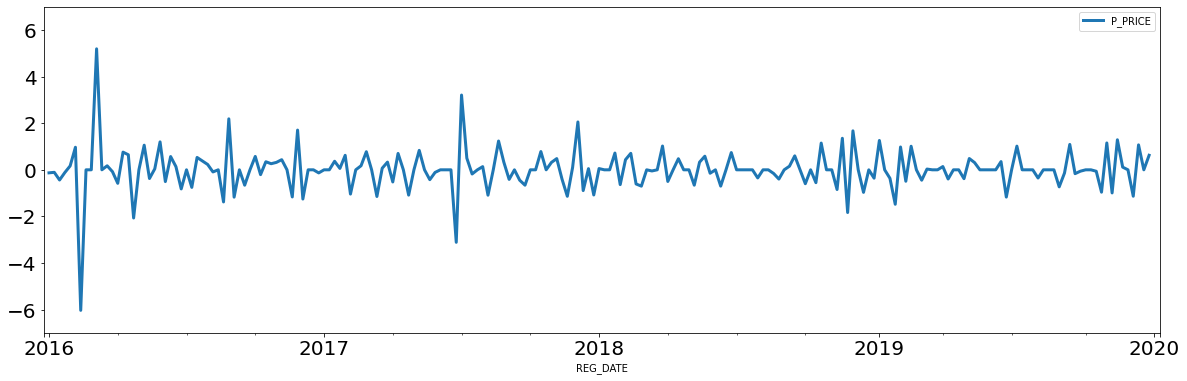

In [23]:
final_df[['P_PRICE']].diff().plot(kind='line', figsize=(20, 6),
                                              linewidth=3, fontsize=20,
                                              xlim=('2015-12-28	','2020-01-10'),
                                              ylim = (-7, 7))

In [25]:
diff = final_df[['P_PRICE']].diff()
diff.fillna(method='ffill', inplace=True)
diff.fillna(method='bfill', inplace=True)

diff.columns = ['price_diff']

if 'price_diff' not in final_df.columns:
  final_df = pd.concat([final_df, diff], axis=1)
final_df.head()

,P_PRICE,year,week,cpi_total,cpi_fish,oil,wind_kr,temperature_kr,water_temp_kr,Quarter,Quarter_ver2,냉동,자숙,살,CTRY_1_중국,CTRY_2_중국,P_PURPOSE_판매용,CATEGORY_1_갑각류,CATEGORY_2_새우,P_NAME_흰다리새우,price_trend,price_seasonal,count_Day,count_Week,price_diff
REG_DATE,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28,7.785059,2015.0,53.0,100.22,101.26,37.080,5.352941,7.973109,13.732174,4.0,4.0,1,0,1,1,1,1,1,1,1,7.164766,-0.259498,7.524373,7.092923,-0.129938
2016-01-04,7.655120,2016.0,1.0,100.39,100.76,34.626,6.739496,6.356303,13.282051,1.0,5.0,1,1,1,1,1,1,1,1,1,7.164766,-0.356770,7.524373,7.092923,-0.129938
2016-01-11,7.547201,2016.0,2.0,100.39,100.76,30.450,6.095798,5.514286,12.835593,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.061766,7.524373,7.092923,-0.107919
2016-01-18,7.110114,2016.0,3.0,100.39,100.76,29.350,9.819643,0.268750,11.728319,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.178875,7.524373,7.092923,-0.437087
2016-01-25,6.994303,2016.0,4.0,100.39,100.76,32.186,7.211224,4.908163,11.227000,1.0,5.0,1,0,1,1,1,1,1,1,1,7.164766,0.314334,7.326684,7.092923,-0.115811


In [26]:
final_df['price_lag1'] = final_df['P_PRICE'].shift(1)
final_df['price_lag2'] = final_df['P_PRICE'].shift(2)

In [27]:
final_df['price_lag1'].fillna(method='bfill', inplace=True)
final_df['price_lag2'].fillna(method='bfill', inplace=True)

In [28]:
kind_train, kind_test = train_test_split(final_df, test_size=0.2, random_state=0)
X_train,X_test,Y_train,Y_test =train_test_split(final_df.drop('P_PRICE', axis=1), final_df['P_PRICE'], test_size=0.2, random_state=0)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(168, 26) (168,)
(42, 26) (42,)


In [29]:
kind_train = final_df.loc[final_df.index < '2018-06-01', :]
kind_test = final_df.loc[final_df.index >= '2018-06-01', :]

In [30]:
Y_train = kind_train['P_PRICE']
X_train = kind_train.drop('P_PRICE', axis=1)
Y_test = kind_test['P_PRICE']
X_test = kind_test.drop('P_PRICE', axis=1)

In [31]:
fit_reg1 = sm.OLS(Y_train, X_train).fit()
fit_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_PRICE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.335e+04
Date:                Thu, 02 Sep 2021   Prob (F-statistic):          2.52e-209
Time:                        21:18:13   Log-Likelihood:                 400.53
No. Observations:                 127   AIC:                            -765.1
Df Residuals:                     109   BIC:                            -713.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
year              -0.0005      0.000     -2.042      0.044      -0.001   -1.39e-05
week              -0.0001      0.000     -0.397      0.692      -0.001       0.001
cpi_total          0.0105      0.005      2.217      0.029       0.001       0.020
cpi_fish           0.0013      0.002      0.815      0.417      -0.002       0.004
oil            -9.695e-05      0.000     -0.301      0.764      -0.001       0.001
wind_kr           -0.0025      0.001     -1.925      0.057      -0.005    7.24e-05
temperature_kr    -0.0011      0.001     -1.848      0.067      -0.002    7.69e-05
water_temp_kr      0.0006      0.001      0.704      0.483      -0.001       0.002
Quarter            0.0073      0.005      1.386      0.169      -0.003       0.018
Quarter_ver2      -0.0053      0.003     -1.973      0.051      -0.011    2.46e-05
냉동              1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
자숙                -0.0001      0.004     -0.028      0.978      -0.008       0.008
살               1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
CTRY_1_중국       1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
CTRY_2_중국       1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
P_PURPOSE_판매용   1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
CATEGORY_1_갑각류  1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
CATEGORY_2_새우   1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
P_NAME_흰다리새우    1.328e-06   8.14e-07      1.631      0.106   -2.86e-07    2.94e-06
price_trend       -0.0208      0.010     -2.151      0.034      -0.040      -0.002
price_seasonal    -0.0055      0.004     -1.346      0.181      -0.014       0.003
count_Day         -0.0004      0.005     -0.092      0.927      -0.010       0.009
count_Week        -0.0069      0.011     -0.619      0.537      -0.029       0.015
price_diff         1.0013      0.002    616.722      0.000       0.998       1.005
price_lag1         1.0010      0.003    392.252      0.000       0.996       1.006
price_lag2         0.0005      0.002      0.256      0.798      -0.004       0.005
==============================================================================
Omnibus:                      231.619   Durbin-Watson:                   1.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34361.809
Skew:                           8.085   Prob(JB):                         0.00
Kurtosis:                      81.944   Cond. No.                     2.25e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-24. This might indicate that there are
strong multicollinearit